<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
torch.manual_seed(42)

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [6]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
word_count = {}
for text in tqdm(dataset['train']['text']):
    for sentence in sent_tokenize(text):
        sen_len = len(word_tokenize(sentence))
        if sen_len not in word_count:
            word_count[sen_len] = 1
        else:
            word_count[sen_len] += 1

  0%|          | 0/25000 [00:00<?, ?it/s]

Посмотрим на распределение числа слов в предложениях:

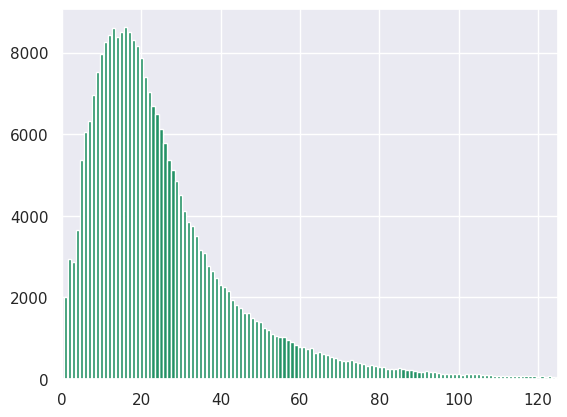

In [8]:
plt.bar(list(word_count.keys()), word_count.values())
plt.xlim(0, 125)
plt.show()

In [9]:
sentences = []
word_threshold = 32

for text in tqdm(dataset['train']['text']):
    for sentence in sent_tokenize(text):
        tokenized = word_tokenize(sentence)
        if len(sentence) > 0:
            sentences.append([x.lower() for x in tokenized if len(tokenized) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [10]:
print("Всего предложений:", len(sentences))

Всего предложений: 271057


Посчитаем для каждого слова его встречаемость.

In [11]:
words = Counter()

for sentence in tqdm(sentences):
    for word in sentence:
        words[word] += 1

  0%|          | 0/271057 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [12]:
len(words)

68416

In [13]:
vocab = set()
vocab_size = 40000
vocab.update(np.array(words.most_common(n=vocab_size))[:, 0])
vocab.update(['<unk>', '<bos>', '<eos>', '<pad>'])

In [14]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [15]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [16]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [17]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        tokenized_sentence.append(self.bos_id)
        for word in self.data[idx]:
            tokenized_sentence.append(word2ind.get(word, self.unk_id))
        tokenized_sentence.append(self.eos_id)

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [18]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [19]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возможные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [20]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="val_dataloader"):
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [21]:
def train_model(model, optimizer, criterion, tr_loader, val_loader, epochs, scheduler=None):
    tr_perplexity = []
    val_perplexity = []
    for epoch in tqdm(range(epochs), desc="epochs"):
        model.train(True)
        perplexity = []
        for batch in tqdm(tr_loader, desc="train_dataloader"):
            input = batch['input_ids']
            logits = model(input).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            perplexity.append(torch.exp(loss).item())

        if scheduler:
            scheduler.step()

        tr_perplexity.append(torch.mean(torch.Tensor(perplexity)).item())
        val_perplexity.append(evaluate(model, criterion, val_loader))
        print(f"Perplexity. Train: {tr_perplexity[-1]}, validation: {val_perplexity[-1]}")

    return tr_perplexity, val_perplexity

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

Начнём с RNN:

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim, padding_idx=word2ind['<pad>'])
        self.rnn = nn.RNN(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.projection = nn.Linear(in_features=hidden_dim, out_features=vocab_size)

        self.non_lin = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        outputs, _ = self.rnn(embeddings)
        outputs = self.linear(self.non_lin(outputs))

        return self.projection(outputs)

In [ ]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

tr_perplexity, val_perplexity = train_model(model, optimizer, criterion, train_dataloader, test_dataloader, 10)

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 333.527587890625, validation: 113.444602591683


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 104.87968444824219, validation: 90.69339548314484


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 84.9153060913086, validation: 80.91766966188483


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 73.09101104736328, validation: 75.9375381901987


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 64.76959228515625, validation: 70.07607492621605


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 58.701507568359375, validation: 67.29719907636346


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 54.41664505004883, validation: 64.69248642889929


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 50.547630310058594, validation: 63.00431959172034


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 47.553863525390625, validation: 61.55668932272647


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 45.89126205444336, validation: 60.25468319828945
Perplexity. Train: 45.89126205444336, validation: 60.25468319828945


In [ ]:
evaluate(model, criterion, test_dataloader)

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

60.25468319828945

In [22]:
def handle_history(tr_perplexity, val_perplexity):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))

    axs[0].plot(tr_perplexity)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Perplexity')
    axs[0].set_title('Perplexity dependence on epoch, train')

    axs[1].plot(val_perplexity)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Perplexity')
    axs[1].set_title('Perplexity dependence on epoch, validation')

    plt.grid(True)
    plt.show()

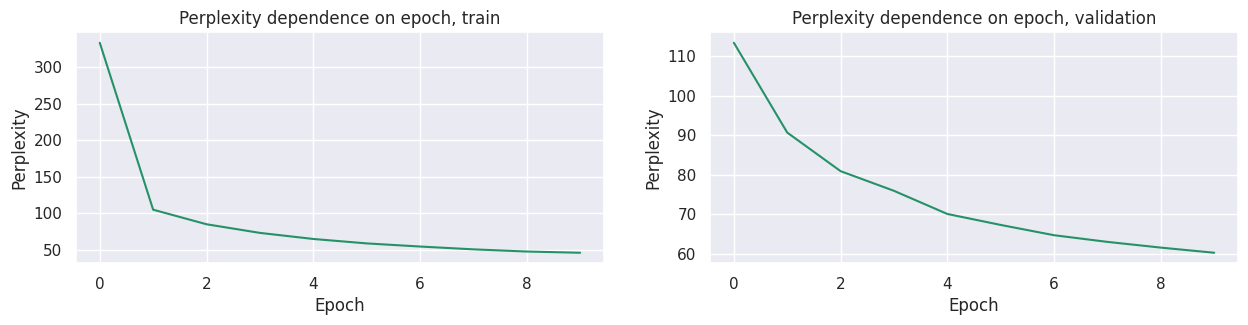

In [ ]:
handle_history(tr_perplexity, val_perplexity)

Попробуем жадным образом сгенерировать какую-нибудь последовательность:

In [39]:
def generate_sequence(model, prefix_seq, max_seq_len = 50):
    input_ids = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(prefix_seq)]
    result = torch.IntTensor(input_ids).to(device)[None, :]
    with torch.no_grad():
        while result.shape[1] < max_seq_len:
            output = model(result)
            next_word_id = torch.argmax(output[0][result.shape[1] - 1]).item()
            result = torch.cat((result, torch.IntTensor([next_word_id])[None, :].to(device)), dim=1)
            next_word = ind2word[next_word_id]
            print("next word: ", next_word)
            if next_word == '<eos>':
                break

In [ ]:
generate_sequence(model, "The football is ")

next word:  a
next word:  great
next word:  film
next word:  ,
next word:  but
next word:  it
next word:  is
next word:  not
next word:  a
next word:  good
next word:  movie
next word:  .
next word:  <eos>


Я считаю, результат приемлемый :)

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
class LanguageModelLSTM1(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim, padding_idx=word2ind['<pad>'])
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=2, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(in_features=2*hidden_dim, out_features=hidden_dim)
        self.projection = nn.Linear(in_features=hidden_dim, out_features=vocab_size)

        self.layer_norm = nn.LayerNorm(2*hidden_dim)
        self.non_lin = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        outputs, _ = self.lstm(embeddings)
        outputs = self.linear(self.non_lin(self.layer_norm(outputs)))

        return self.projection(outputs)

In [ ]:
model = LanguageModelLSTM1(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

tr_perplexity, val_perplexity = train_model(model, optimizer, criterion, train_dataloader, test_dataloader, 5, scheduler=scheduler)

epochs:   0%|          | 0/5 [00:00<?, ?it/s]

train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 67.05347442626953, validation: 1.038866352989946


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 1.0222208499908447, validation: 1.0169252240511468


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 1.0061321258544922, validation: 1.0235487208037697


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 1.0068230628967285, validation: 1.0187695958459007


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 1.0034350156784058, validation: 1.0202154390535003


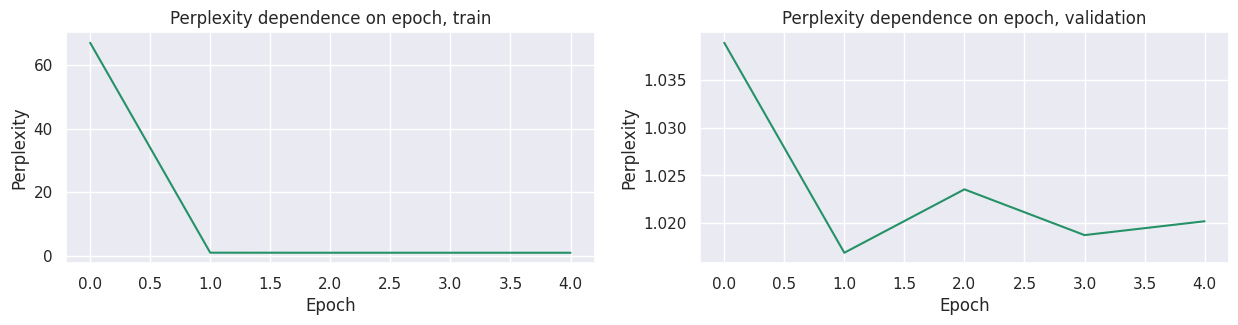

In [ ]:
handle_history(tr_perplexity, val_perplexity)

Снова сгенерируем последовательность:

In [ ]:
generate_sequence(model, "The football is ")

next word:  <eos>


Что-то пошло не так... И графики зависимости перплексии от эпохи обучения намекают на то, что где-то происходит утечка таргетов. Проблема заключается в том, что при использовании двунаправленного RNN на проходе в обратную сторону мы кодируем информацию о таргетах. Решить проблему можно следующим образом: вместо предсказания для очереднего токена предложения следующего за ним токена можно предсказывать следующий токен для префикса предложения. Таким образом, модель будет возвращать вероятностное распределение следующего токена для некоторого префикса предложения и функция потерь изменится (сумма функций кросс-энтропии заменится на кросс-энтропию). Заметим, что в таком случае размер обучающей выборки увеличится в разы.

In [35]:
class LanguageModelLSTM2(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim, padding_idx=word2ind['<pad>'])
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=2, bidirectional=False, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.projection = nn.Linear(in_features=hidden_dim, out_features=vocab_size)

        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.non_lin = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        outputs, _ = self.lstm(embeddings)
        outputs = self.linear(self.non_lin(self.layer_norm(outputs)))

        return self.projection(outputs)

In [36]:
model = LanguageModelLSTM2(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

tr_perplexity, val_perplexity = train_model(model, optimizer, criterion, train_dataloader, test_dataloader, 10, scheduler=scheduler)

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 250.79916381835938, validation: 93.3186135872903


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 87.62348175048828, validation: 71.41416117422304


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 68.76763916015625, validation: 60.430127735516166


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 56.99212646484375, validation: 53.634959378481135


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 48.5432243347168, validation: 48.91063683341425


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 37.219451904296875, validation: 42.69562075203381


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 34.642982482910156, validation: 41.37782241309781


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 33.35373306274414, validation: 40.490455459940534


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 32.36977767944336, validation: 39.76956030869957


train_dataloader:   0%|          | 0/1695 [00:00<?, ?it/s]

val_dataloader:   0%|          | 0/1059 [00:00<?, ?it/s]

Perplexity. Train: 31.534212112426758, validation: 39.14016764157217


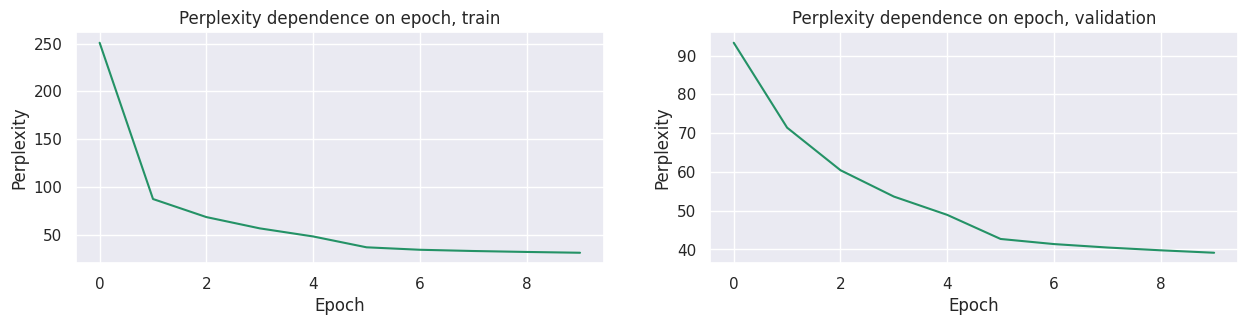

In [37]:
handle_history(tr_perplexity, val_perplexity)

In [46]:
generate_sequence(model, "Don't repeat yourself")

next word:  ,
next word:  but
next word:  i
next word:  do
next word:  n't
next word:  think
next word:  i
next word:  'll
next word:  be
next word:  able
next word:  to
next word:  see
next word:  this
next word:  movie
next word:  .
next word:  <eos>


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.


*  **Архитектуры моделей и их обучение**

    Первая модель представляет из себя достаточно простую архитектуру без регуляризаций: однослойная классическая RNN с проекцией в пространство токенов и полносвязным линейным слоем.

    Во второй модели я заменил классическую RNN на LSTM, увеличил число слоёв до двух, а также добавил LayerNorm на выходе LSTM. При выборе между BatchNorm и LayerNorm, я отдал предпочтение LayerNorm, поскольку наслышан, что с его использованием можно добиться результатов несколько лучше.

    Модели выше обучались в течение 10 эпох с оптимизатором AdamW с начальным значением lr=1e-3, причём во втором случае по истечении первых 5 эпох обучения значение lr уменьшается в 10 раз.

*  **Результаты экспериментов**

    В обоих экспериментах значение перплексии падало в течение всего обучения как на трейне, так и на валидации. Но во втором эксперименте, как и ожидалось, к концу обучения на валидации удалось достичь меньшего значения перплексии. Качество генерации в обоих случаях оставляет желать лучшего, хоть сгенерированные сообщения и несут в себе некоторый смысл. Стоит отметить, что обе модели генерируют последовательности про кино, фильмы и актёров. Это соответствует тематике корпуса текстов, который мы выбрали для обучения.


*  **Идеи для улучшения**
    
    Можно попробовать использовать другие оптимизаторы, использовать техники lr-scheduling'а. Кажется, что предобучать эмбеддинги для токенов (слов) смысла особо нет, т.к. нейросеть, как мне кажется, и сама неплохо справляется с их обучением. Для частичного решения проблемы забывания контекста можно всё же использовать двунаправленную RNN, но тогда придётся обновить обучающую выборку и функцию потерь. Также имеет смысл вспомнить про механизм Attention, который и решает проблему выше.